In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

repo_name = "hurricane-harm-herald"
target_dir = "/content/drive/MyDrive/ai4er/python/hurricane"
os.chdir(target_dir)
print(os.getcwd())

/content/drive/MyDrive/ai4er/python/hurricane


In [3]:
#%cd /content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data
%cd /content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/notebooks

/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/notebooks


In [9]:
#paths of data
building_locs_path='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/processed_data/metadata_pickle/df_points_posthurr.pkl'

# The path of dem file
folder='/content/drive/MyDrive/DEM_data/'
dem_name=['ASTGTMV003_N29_30_W096_dem.tif','ASTGTMV003_N30W086_dem.tif','ASTGTMV003_N18W074_75_dem.tif','ASTGTMV003_N33_34W080_78_dem.tif']

# read the coastline data (points) 
coast_data_path='/content/drive/MyDrive/coast_10m.xlsx'

# path to store Terrain_EFs
path_Terrain_EFs='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/processed_data/Terrian_EFs.pkl'

In [6]:
!pip install rasterio #install required packs
!pip install richdem
!pip install geopandas
!pip install vptree geographiclib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 68.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 KB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for richdem: filename=richdem-0.3.4-cp38-cp38-linux_x86_64.whl size=7997109 sha256=b8fa1b780eb28e23c63a980b3a41cd5dbd472cbd48e46ae2d006d4305248d736
  Stored in directory: /root/.cache/pip/wheels/9f/9c/61/8da642da1b65cbf887fa5d335778dfcefe22fba629e6b055d4
Successfully built richdem
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
# import
import numpy as np
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import richdem as rd
from scipy.interpolate import interp2d
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import pickle
import vptree
from geographiclib.geodesic import Geodesic

In [11]:
#load the data for the location (lon, lat) of buildings
with open(building_locs_path, 'rb') as f:
    building_locs = pickle.load(f)

building_locs.head()

,geometry,damage_class,disaster_name,capture_date
0,POINT (-77.92443 34.78850),2,hurricane-florence,2018-09-20 16:04:41+00:00
1,POINT (-77.92459 34.78817),1,hurricane-florence,2018-09-20 16:04:41+00:00
2,POINT (-85.61007 30.20004),0,hurricane-michael,2018-10-13 16:48:15+00:00
3,POINT (-85.61057 30.20001),0,hurricane-michael,2018-10-13 16:48:15+00:00
4,POINT (-85.61055 30.20060),1,hurricane-michael,2018-10-13 16:48:15+00:00


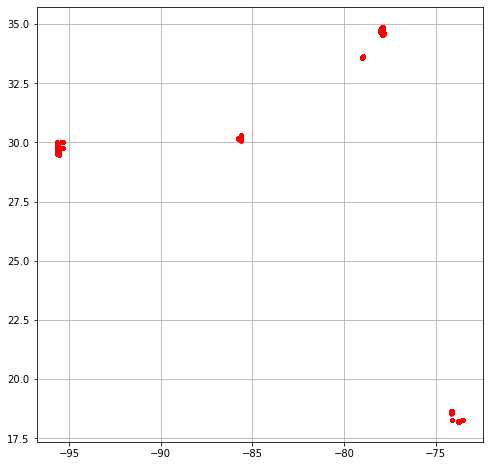

In [12]:
building_locs['lat'],building_locs['lon']=building_locs['geometry'].y,building_locs['geometry'].x # getting the lat and lon of the building locations
fig, ax= plt.subplots(figsize=(8,8))
plt.plot(building_locs['lon'],building_locs['lat'],'r.')
plt.grid('on')
plt.show()

In [13]:
building_locs.head()

,geometry,damage_class,disaster_name,capture_date,lat,lon
0,POINT (-77.92443 34.78850),2,hurricane-florence,2018-09-20 16:04:41+00:00,34.788502,-77.924432
1,POINT (-77.92459 34.78817),1,hurricane-florence,2018-09-20 16:04:41+00:00,34.788174,-77.924586
2,POINT (-85.61007 30.20004),0,hurricane-michael,2018-10-13 16:48:15+00:00,30.200042,-85.610074
3,POINT (-85.61057 30.20001),0,hurricane-michael,2018-10-13 16:48:15+00:00,30.200012,-85.610569
4,POINT (-85.61055 30.20060),1,hurricane-michael,2018-10-13 16:48:15+00:00,30.200601,-85.610547


In [14]:
# seperate the lat and lon into four different clusters

index1=(building_locs['lat']<=32.5) & (building_locs['lat']>=27.5)&(building_locs['lon']<-95)
df1=pd.DataFrame({'latitude':building_locs['lat'][index1],'longitude':building_locs['lon'][index1]})
gdf1=gpd.GeoDataFrame(df1,geometry=gpd.points_from_xy(df1.longitude,df1.latitude), crs=4326)

index2=(building_locs['lat']<=31) & (building_locs['lat']>=27.5)&(building_locs['lon']<-85)&(building_locs['lon']>-90)
df2=pd.DataFrame({'latitude':building_locs['lat'][index2],'longitude':building_locs['lon'][index2]})
gdf2=gpd.GeoDataFrame(df2,geometry=gpd.points_from_xy(df2.longitude,df2.latitude), crs=4326)

index3=(building_locs['lat']<=20) & (building_locs['lat']>=17.5)&(building_locs['lon']<-70)&(building_locs['lon']>-75)
df3=pd.DataFrame({'latitude':building_locs['lat'][index3],'longitude':building_locs['lon'][index3]})
gdf3=gpd.GeoDataFrame(df3,geometry=gpd.points_from_xy(df3.longitude,df3.latitude), crs=4326)

index4=(building_locs['lat']<=35) & (building_locs['lat']>=32.5)&(building_locs['lon']<-75)&(building_locs['lon']>-80)
df4=pd.DataFrame({'latitude':building_locs['lat'][index4],'longitude':building_locs['lon'][index4]})
gdf4=gpd.GeoDataFrame(df4,geometry=gpd.points_from_xy(df4.longitude,df4.latitude), crs=4326)


In [15]:
def lonlat2xy(lon,lat,dem): # This function convert longitude and latitude to x and y
  rows, cols = rio.transform.rowcol(dem.transform, lon, lat)
  return cols,rows

def get_height(df,dem): # get the height of the given location (given by lon and lat)
  coord_list = [(x,y) for x,y in zip(df['longitude'], df['latitude'])]
  data=[x for x in dem.sample(coord_list,1)]
  df['elevation'] =np.array(data)
  return df

def get_height_v2(cols,rows,dem_array): # get the height of the given location (given by lon and lat)
  x=np.arange(0,np.size(dem_array,1),1)
  y=np.arange(0,np.size(dem_array,0),1)
  f = interp2d(x,y,dem_array, kind='linear') #interploate
  #H_all=np.array([np.zeros(len(cols),1)])
  #for i in range(0,len(cols)):
  #H = f(cols[i],rows[i])
  H_all=np.zeros([len(cols),1])
  for i in range(0,len(cols)):
     height=f(cols[i],rows[i])
     H_all[i]=height
  return H_all

def get_slope(cols,rows,slope):# get the slope of the given location (given by lon and lat)
  x=np.arange(0,np.size(slope,1),1)
  y=np.arange(0,np.size(slope,0),1)
  f = interp2d(x,y,slope, kind='linear') #interploate
  S_all=np.zeros([len(cols),1])
  for i in range(0,len(cols)):
     s=f(cols[i],rows[i])
     S_all[i]=s
  return S_all
  '''
  S = f(cols,rows)
  S=np.diagonal(S)
  return S
'''
def get_aspect(cols,lat,aspect): # get the aspect of the given location (given by lon and lat)
  x=np.arange(0,np.size(aspect,1),1)
  y=np.arange(0,np.size(aspect,0),1)
  f = interp2d(x,y,aspect, kind='linear') #interploate
  A_all=np.zeros([len(cols),1])
  for i in range(0,len(cols)):
     a=f(cols[i],rows[i])
     A_all[i]=a
  return A_all

  '''
  A = f(cols,lat)
  A=np.diagonal(A)
  return A
  '''

In [16]:
#Check data
df1.head()

,latitude,longitude,geometry
1415,29.744722,-95.634710,POINT (-95.63471 29.74472)
1416,29.744546,-95.634738,POINT (-95.63474 29.74455)
1417,29.744307,-95.634755,POINT (-95.63475 29.74431)
1418,29.743906,-95.634733,POINT (-95.63473 29.74391)
1419,29.743680,-95.634683,POINT (-95.63468 29.74368)


In [17]:
# get the heigh, slope and aspect in building locations 
for i in range(0,len(dem_name)):
  dem_path=folder+dem_name[i]
  dem = rio.open(dem_path)
  dem_array = dem.read(1).astype('float64')
  dem4slope  = rd.rdarray(dem_array, no_data=-9999) 
  slope = rd.TerrainAttribute(dem4slope, attrib='slope_riserun') #calculate slope
  aspect = rd.TerrainAttribute(dem4slope, attrib='aspect') # calculate aspect
  if i==0:
    df1=get_height(df1,dem)
    cols,rows=lonlat2xy(df1['longitude'].values,df1['latitude'].values,dem)
    #df1['elevation_v2']=get_height_v2(cols,rows,dem_array)
    df1['slope']=get_slope(cols,rows,slope)
    df1['aspect']=get_aspect(cols,rows,aspect)
    
  if i==1:
    df2=get_height(df2,dem)
    cols,rows=lonlat2xy(df2['longitude'].values,df2['latitude'].values,dem)
    df2['slope']=get_slope(cols,rows,slope)
    df2['aspect']=get_aspect(cols,rows,aspect)
  if i==2:
    df3=get_height(df3,dem)
    cols,rows=lonlat2xy(df3['longitude'].values,df3['latitude'].values,dem)
    df3['slope']=get_slope(cols,rows,slope)
    df3['aspect']=get_aspect(cols,rows,aspect)
  if i==3:
    df4=get_height(df4,dem)
    cols,rows=lonlat2xy(df4['longitude'].values,df4['latitude'].values,dem)
    df4['slope']=get_slope(cols,rows,slope)
    df4['aspect']=get_aspect(cols,rows,aspect)



Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top 

In [18]:
df1.head() #check

,latitude,longitude,geometry,elevation,slope,aspect
1415,29.744722,-95.634710,POINT (-95.63471 29.74472),34,4.246322,132.614059
1416,29.744546,-95.634738,POINT (-95.63474 29.74455),31,3.925080,99.162346
1417,29.744307,-95.634755,POINT (-95.63475 29.74431),31,3.925080,99.162346
1418,29.743906,-95.634733,POINT (-95.63473 29.74391),30,0.728869,210.963760
1419,29.743680,-95.634683,POINT (-95.63468 29.74368),31,2.371708,288.434937


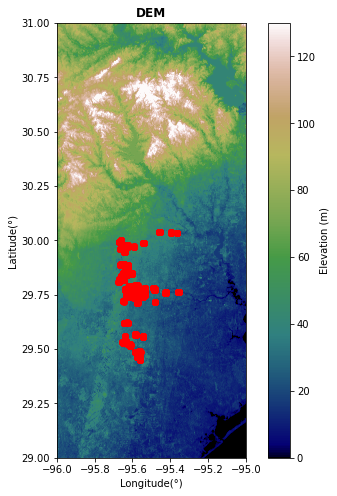

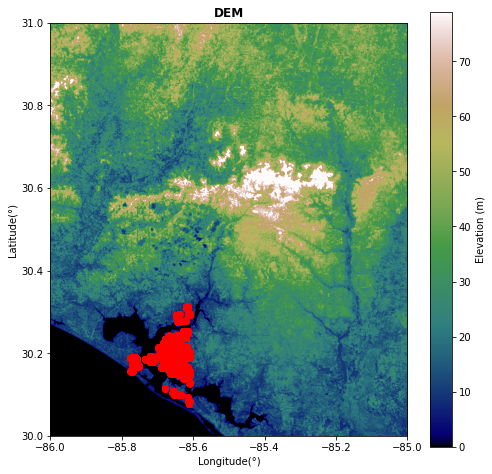

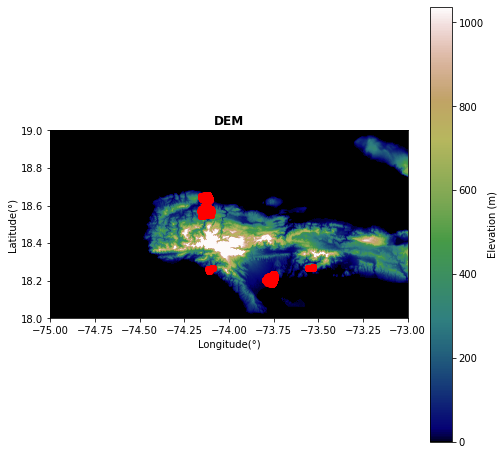

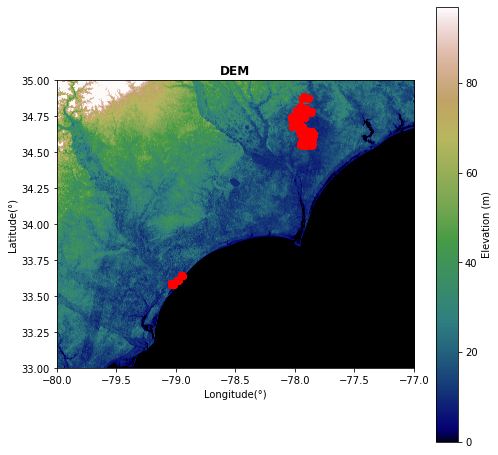

In [19]:
# plot dem map and building locations 

for i in range(0,len(dem_name)):
  dem_path=folder+dem_name[i]
  dem = rio.open(dem_path)
  dem_array = dem.read(1).astype('float64')
  fig, ax= plt.subplots(figsize=(8,8))
  handle=rio.plot.show(dem_array,transform=dem.transform,ax=ax,title='DEM',cmap='gist_earth',vmin=0,vmax=np.percentile(dem_array,99)) #plot DEM map 
  if i==0:
    gdf1.plot(ax=handle,color='red') #plot location of buildings
  if i==1:
    gdf2.plot(ax=handle,color='red')
  if i==2:
    gdf3.plot(ax=handle,color='red')
  if i==3:
    gdf4.plot(ax=handle,color='red')

  im = handle.get_images()[0]
  cbar=fig.colorbar(im,ax=ax)
  cbar.set_label('Elevation (m)')
  ax.set_xlabel('Longitude(°)')
  ax.set_ylabel('Latitude(°)')



EPSG:4326
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
EPSG:4326
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
EPSG:4326
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
EPSG:4326
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


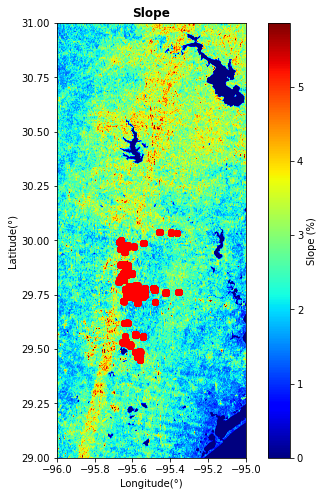

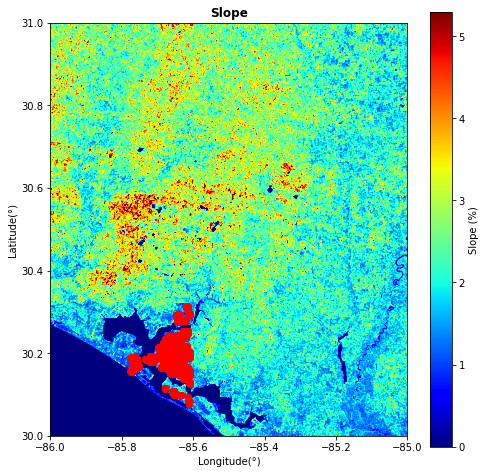

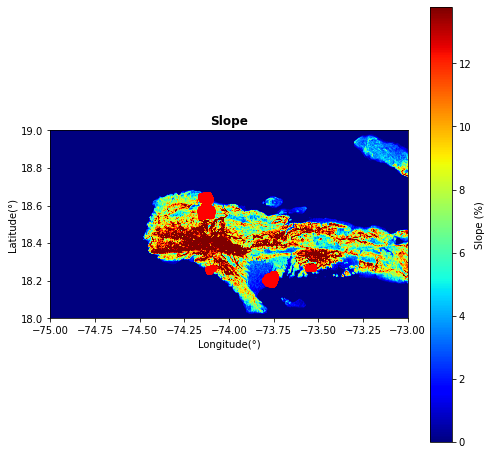

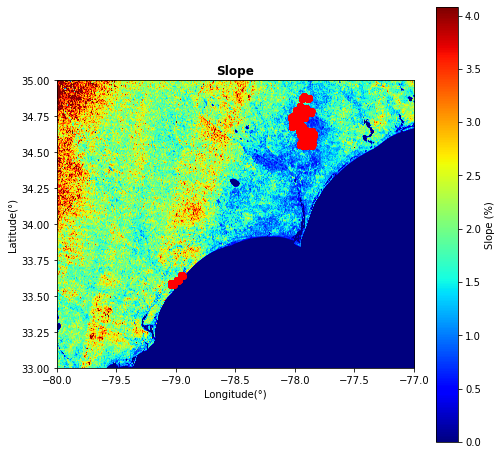

In [20]:
# plot slope map and building locations 
for i in range(0,len(dem_name)):
  dem_path=folder+dem_name[i]
  dem = rio.open(dem_path)
  print(dem.crs)
  dem_array = dem.read(1).astype('float64')
  dem4slope  = rd.rdarray(dem_array, no_data=-9999) 
  slope = rd.TerrainAttribute(dem4slope, attrib='slope_riserun') #calculate slope
  fig, ax= plt.subplots(figsize=(8,8))
  handle=rio.plot.show(slope,transform=dem.transform,ax=ax,title='Slope',cmap='jet',vmin=0,vmax=np.percentile(slope,95)) #plot DEM map 
  if i==0:
    gdf1.plot(ax=handle,color='red') #plot location of buildings
  if i==1:
    gdf2.plot(ax=handle,color='red')
  if i==2:
    gdf3.plot(ax=handle,color='red')
  if i==3:
    gdf4.plot(ax=handle,color='red')

  im = handle.get_images()[0]
  cbar=fig.colorbar(im,ax=ax)
  cbar.set_label('Slope (%)')
  ax.set_xlabel('Longitude(°)')
  ax.set_ylabel('Latitude(°)')

EPSG:4326
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
EPSG:4326
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
EPSG:4326
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
EPSG:4326
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


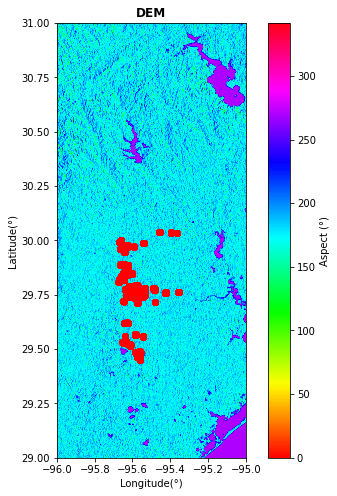

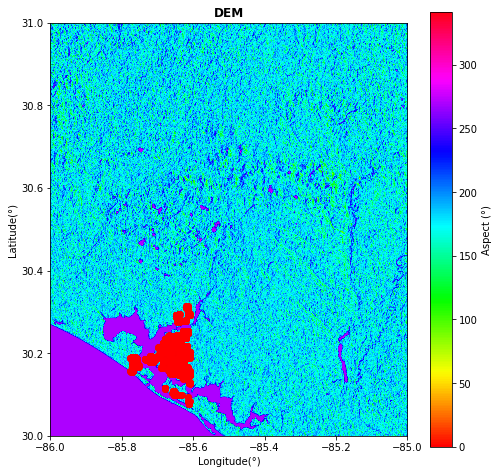

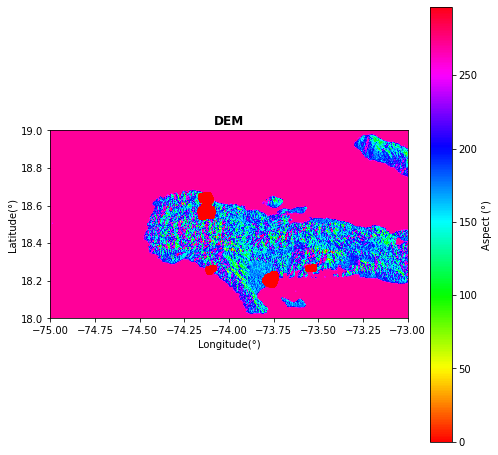

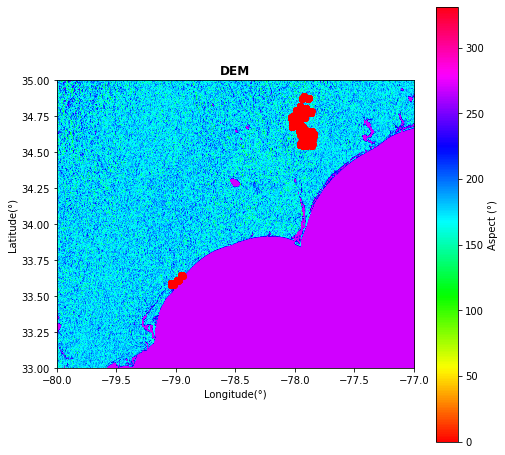

In [23]:
# plot aspect map and building locations 
for i in range(0,len(dem_name)):
  dem_path=folder+dem_name[i]
  dem = rio.open(dem_path)
  print(dem.crs)
  dem_array = dem.read(1).astype('float64')
  dem4slope  = rd.rdarray(dem_array, no_data=-9999) 
  aspect = rd.TerrainAttribute(dem4slope, attrib='aspect') # calculate aspect
  fig, ax= plt.subplots(figsize=(8,8))
  handle=rio.plot.show(aspect,transform=dem.transform,ax=ax,title='DEM',cmap='hsv',vmin=0,vmax=np.percentile(aspect,95)) #plot DEM map 
  if i==0:
    gdf1.plot(ax=handle,color='red') #plot location of buildings
  if i==1:
    gdf2.plot(ax=handle,color='red')
  if i==2:
    gdf3.plot(ax=handle,color='red')
  if i==3:
    gdf4.plot(ax=handle,color='red')

  im = handle.get_images()[0]
  cbar=fig.colorbar(im,ax=ax)
  cbar.set_label('Aspect (°)')
  ax.set_xlabel('Longitude(°)')
  ax.set_ylabel('Latitude(°)')

In [ ]:
####################################### the following code calculate the distance to the coast

In [24]:
def geoddist(p1, p2):# calculate Geodesic distance between two points
  # p1 = [lon1, lat1] in degrees
  # p2 = [lon2, lat2] in degrees
  return Geodesic.WGS84.Inverse(p1[1], p1[0], p2[1], p2[0])['s12']

In [25]:
coast=pd.read_excel(coast_data_path) 
coast=coast.values
print(coast)

[[-71.50739497  17.55125561]
 [-71.48253333  17.57562897]
 [-71.46711178  17.58026764]
 ...
 [-76.85716244  25.52387917]
 [-76.84462522  25.52622989]
 [-76.82895372  25.53171492]]


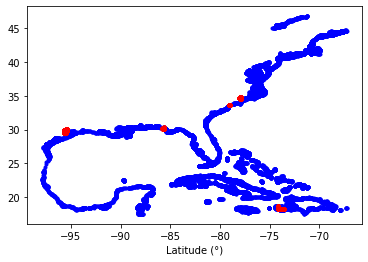

In [26]:
plt.plot(coast[:,0],coast[:,1],'b.') # plot the coastline and building locations
plt.plot(building_locs['lon'].values,building_locs['lat'].values,'r.')
plt.xlabel('Longitude (°)')
plt.xlabel('Latitude (°)')
plt.show()

In [27]:
# find the closest point on the coastline to the building and return the distance
# NOTE! this cell is quite time consuming to run (~5 to 6 mins)
buildings=np.zeros([len(building_locs['lon']),2])
for i in range(0,len(building_locs['lon'])):
  buildings[i,:]=np.array([building_locs['lon'][i],building_locs['lat'][i]])

closestp=np.zeros([len(buildings),2])# to store the closest point in the coast to a given building
distance=np.zeros([len(buildings),1])# to store the building's distance to the coast

coast_vp = vptree.VPTree(coast, geoddist)  #build the lookup table
print('Building closest-coast dist')
for i in range(0,len(buildings)):
  data = coast_vp.get_nearest_neighbor(buildings[i,:])
  closestp[i,:]=data[1]
  distance[i]=data[0]


Building closest-coast dist


In [28]:
print(building_locs['damage_class'][index1].index)

Int64Index([ 1415,  1416,  1417,  1418,  1419,  1420,  1421,  1422,  1423,
             1424,
            ...
            23031, 23032, 23033, 23034, 23035, 23036, 23037, 23038, 23039,
            23040],
           dtype='int64', length=7226)


In [29]:
# merge data
#print(building_locs[index1].index)
#print(building_locs['lon'][index1].index)
#type(building_locs['lon'])
# pack the data
#Terrian_EFs=building_locs
#

df1['dis2coast']=distance[building_locs['lat'][index1].index]
df2['dis2coast']=distance[building_locs['lat'][index2].index]
df3['dis2coast']=distance[building_locs['lat'][index3].index]
df4['dis2coast']=distance[building_locs['lat'][index4].index]

df12 = pd.DataFrame(df1.append(df2,ignore_index = False))
df34 = pd.DataFrame(df3.append(df4,ignore_index = False))
Terrian_EFs=pd.DataFrame(df12.append(df34,ignore_index = False))
#np.shape(Terrian_EFs['latitude'])
#np.shape(df['latitude'])
#df.head()
#df.head()
Terrian_EFs=Terrian_EFs.sort_index()
print(type(Terrian_EFs))
Terrian_EFs.head()

<class 'pandas.core.frame.DataFrame'>


,latitude,longitude,geometry,elevation,slope,aspect,dis2coast
0,34.788502,-77.924432,POINT (-77.92443 34.78850),9,0.530330,135.000000,44915.193168
1,34.788174,-77.924586,POINT (-77.92459 34.78817),7,0.559017,116.565048,44926.181407
2,30.200042,-85.610074,POINT (-85.61007 30.20004),18,2.915476,30.963757,5134.550778
3,30.200012,-85.610569,POINT (-85.61057 30.20001),15,4.257347,310.236359,5130.894941
4,30.200601,-85.610547,POINT (-85.61055 30.20060),11,2.236068,296.565063,5066.617333


In [ ]:
'''
temp=building_locs

temp['elevation']=np.zeros([len(building_locs['lon']),1])
temp['slope']=np.zeros([len(building_locs['lon']),1])
temp['aspect']=np.zeros([len(building_locs['lon']),1])
temp['dis2coast']=np.zeros([len(building_locs['lon']),1])

temp['elevation'][index1]=df1['elevation'][index1].values
temp['slope'][index1]=df1['slope'][index1].values
temp['aspect'][index1]=df1['aspect'][index1].values
temp['dis2coast'][index1]=df1['dis2coast'][index1].values

temp['elevation'][index2]=df2['elevation'][index2].values
temp['slope'][index2]=df2['slope'][index2].values
temp['aspect'][index2]=df2['aspect'][index2].values
temp['dis2coast'][index2]=df2['dis2coast'][index2].values

temp['elevation'][index3]=df3['elevation'][index3].values
temp['slope'][index3]=df3['slope'][index3].values
temp['aspect'][index3]=df3['aspect'][index3].values
temp['dis2coast'][index3]=df3['dis2coast'][index3].values

temp['elevation'][index4]=df4['elevation'][index4].values
temp['slope'][index4]=df4['slope'][index4].values
temp['aspect'][index4]=df4['aspect'][index4].values
temp['dis2coast'][index4]=df4['dis2coast'][index4].values

temp.head()
'''

"\ntemp=building_locs\n\ntemp['elevation']=np.zeros([len(building_locs['lon']),1])\ntemp['slope']=np.zeros([len(building_locs['lon']),1])\ntemp['aspect']=np.zeros([len(building_locs['lon']),1])\ntemp['dis2coast']=np.zeros([len(building_locs['lon']),1])\n\ntemp['elevation'][index1]=df1['elevation'][index1].values\ntemp['slope'][index1]=df1['slope'][index1].values\ntemp['aspect'][index1]=df1['aspect'][index1].values\ntemp['dis2coast'][index1]=df1['dis2coast'][index1].values\n\ntemp['elevation'][index2]=df2['elevation'][index2].values\ntemp['slope'][index2]=df2['slope'][index2].values\ntemp['aspect'][index2]=df2['aspect'][index2].values\ntemp['dis2coast'][index2]=df2['dis2coast'][index2].values\n\ntemp['elevation'][index3]=df3['elevation'][index3].values\ntemp['slope'][index3]=df3['slope'][index3].values\ntemp['aspect'][index3]=df3['aspect'][index3].values\ntemp['dis2coast'][index3]=df3['dis2coast'][index3].values\n\ntemp['elevation'][index4]=df4['elevation'][index4].values\ntemp['slope']

In [30]:
Terrian_EFs.to_pickle(path_Terrain_EFs) # store the dataframe
# read the stored data for test
with open(path_Terrain_EFs, 'rb') as f:
    Terrian_EFs_test = pickle.load(f)

Terrian_EFs_test.head()

,latitude,longitude,geometry,elevation,slope,aspect,dis2coast
0,34.788502,-77.924432,POINT (-77.92443 34.78850),9,0.530330,135.000000,44915.193168
1,34.788174,-77.924586,POINT (-77.92459 34.78817),7,0.559017,116.565048,44926.181407
2,30.200042,-85.610074,POINT (-85.61007 30.20004),18,2.915476,30.963757,5134.550778
3,30.200012,-85.610569,POINT (-85.61057 30.20001),15,4.257347,310.236359,5130.894941
4,30.200601,-85.610547,POINT (-85.61055 30.20060),11,2.236068,296.565063,5066.617333


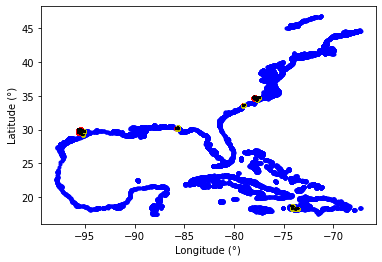

In [33]:
 # plot the coastline (blue points) and building locations (red points) and the closest point on the coastline (yellow points) and connect buildings and their cloest points in coastline with black lines
plt.plot(coast[:,0],coast[:,1],'b.')
plt.plot(buildings[:,0],buildings[:,1],'r.')
plt.plot(closestp[:,0],closestp[:,1],'y.')
plt.plot([buildings[:,0],closestp[:,0]],[buildings[:,1],closestp[:,1]],'k')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.show()

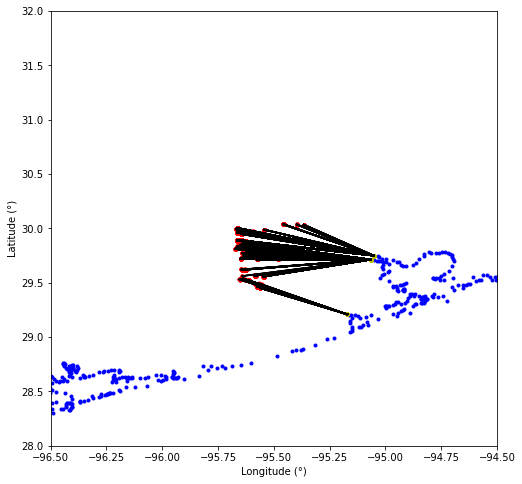

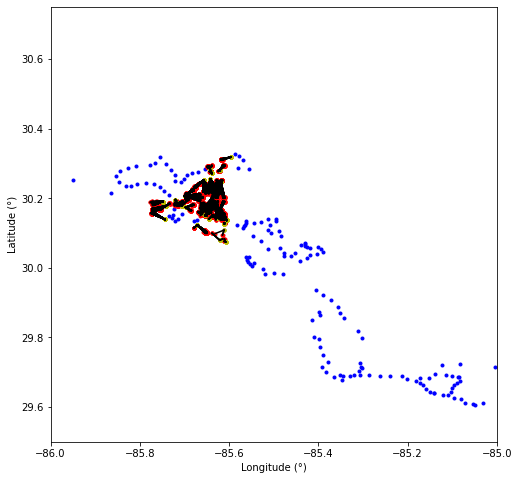

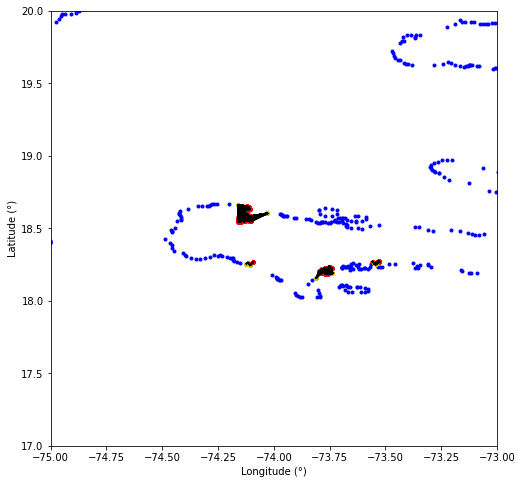

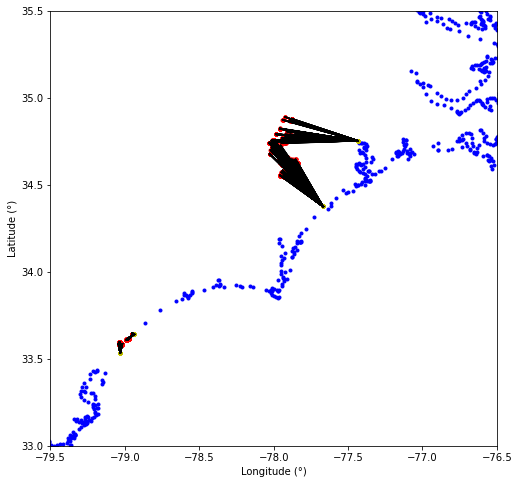

In [32]:
# a zoom in figure,  # plot the coastline (blue points) and building locations (red points) and the closest point on the coastline (yellow points) 
#and connect buildings and their cloest points in coastline with black lines
fig_xlim=[[-96.5,-94.5],[-86,-85],[-75,-73],[-79.5,-76.5]]
fig_ylim=[[28,32],[29.5,30.75],[17,20],[33,35.5]]

for i in range(0,len(fig_xlim)):
  plt.figure(figsize=(8,8))
  plt.plot(coast[:,0],coast[:,1],'b.') 
  plt.plot(buildings[:,0],buildings[:,1],'r.')
  plt.plot(closestp[:,0],closestp[:,1],'y.')
  plt.plot([buildings[:,0],closestp[:,0]],[buildings[:,1],closestp[:,1]],'k')
  plt.xlim(fig_xlim[i])
  plt.ylim(fig_ylim[i])
  plt.xlabel('Longitude (°)')
  plt.ylabel('Latitude (°)')
  plt.show()